# Analysis and plotting of RBD depletion ELISA data for HAARVI serum project

I used commercially-available magnetic beads conjugated to SARS-CoV-2 RBD to deplete serum of RBD-binding antibodies. 
Control pre-pandemic serum spiked with either an RBD-binding monoclonal antibody, rREGN10987 (at 5, 25, or 50 ug/mL) or an NTD-binding antibody (at 50 ug/mL) were also incubated with the RBD beads to get an estimate of how well the depletion works. 

The process of pulling down the RBD antibodies involved diluting the serum 1:4 (because I added 50 uL serum + 150 uL of bead suspension at 1mg/mL). 
In one condition that we will not plot here, I used 2x as many beads, and thus added 50 uL serum + 300 uL of bead suspension, so this was a 1:7 dilution of the initial serum.

The pre-depletion serum was also diluted 1:4 (or 1:7, as appropriate) in PBS + 0.05% BSA (the buffer the beads were suspended in). 

Depletions were performed overnight at 4C in Eppendorf tubes in a tube rotator. 

SARS-CoV-2 RBD and spike ELISAs were performed on these samples to verify the degree of RBD antibody depletion.

Here, I calculate the AUC for pre- vs. post-depletion samples and the fold-change in AUC. 

This is really just a test of whether the depletion worked at all and I don't think it is very useful for anything beyond that (see notes at the end!).

Andrea Loes and I (Allie Greaney) then performed neutralization assays on these samples. 
We started each sample at a slightly different initial dilution to capture the full neutralization curve for each sample, given that each serum has a different neutralization potency (determined in Kate's original paper).

The data that are analyzed in this notebook were pre-processed by Kate's `excel_to_fracinfect` script. 

### Set up Analysis

Import packages.

In [1]:
import itertools
import math
import os
import re
import warnings

from IPython.display import display, HTML

import matplotlib
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from plotnine import *
import seaborn

import neutcurve
from neutcurve.colorschemes import CBMARKERS, CBPALETTE
import seaborn

import sklearn
import scipy.stats

import yaml

In [2]:
warnings.simplefilter('ignore')

Read config file.

In [3]:
with open('rbd_absorption_config.yaml') as f:
    config = yaml.safe_load(f)

Use seaborn theme and change font:

In [4]:
theme_set(theme_seaborn(style='white', context='talk', font='FreeSans', font_scale=1))
plt.style.use('seaborn-white')

In [5]:
resultsdir='results'
os.makedirs(resultsdir, exist_ok=True)

In [6]:
pd.options.display.max_rows = 100

## Titration ELISAs

### Read ELISA Titration Data

I first manipulated the data in R and made a new CSV file that we can read in now. Here I:
* Concatenate files together (if there are multiple)
* Remove samples as indicated in config file
* Replace serum names with `display_names`
* Change `dilution` to `dilution factor`
* Take 1/dilution factor to get the dilution (i.e., a 1:100 dilution is `dilution_factor==100` and `dilution==0.01`

In [7]:
titration_df = pd.DataFrame() # create empty data frame
elisa_samples_ignore = config['elisa_samples_ignore']

for f in config['elisa_input_files']:
    df = pd.read_csv(f)
    titration_df = titration_df.append(df)

titration_df = (titration_df
        .query('serum not in @elisa_samples_ignore'))

titration_df = (titration_df
        .replace({'serum' : config['display_names']})
        .rename(columns={'dilution':'dilution_factor'})
        .assign(depleted= pd.Categorical(titration_df['depleted'], categories=['pre', 'post'], ordered=True),
                dilution=lambda x: 1/x['dilution_factor'],
                ab_serum = titration_df.apply(lambda x: 'antibody' 
                                                   if x['dilution_or_ugpermL']=="ugpermL" 
                                                   else 'serum',
                                                   axis=1)
               )
       )

display(titration_df.head())  # display first few lines

,serum,depleted,ligand,dilution_or_ugpermL,date,dilution_factor,OD450,antibody_ugpermL,replicate,log_dilution,dilution,ab_serum
0,13_d15,pre,RBD,dilution,201020,100.0,3.4429,NaN,1,4.605170,0.010000,serum
1,13_d15,pre,RBD,dilution,201020,300.0,2.6471,NaN,1,5.703782,0.003333,serum
2,13_d15,pre,RBD,dilution,201020,900.0,1.8843,NaN,1,6.802395,0.001111,serum
3,13_d15,pre,RBD,dilution,201020,2700.0,0.9066,NaN,1,7.901007,0.000370,serum
4,13_d15,pre,RBD,dilution,201020,8100.0,0.2911,NaN,1,8.999619,0.000123,serum


In [8]:
titration_df.query('serum=="23_d45 (re-depleted)"')

,serum,depleted,ligand,dilution_or_ugpermL,date,dilution_factor,OD450,antibody_ugpermL,replicate,log_dilution,dilution,ab_serum


### Plot ELISA data pre- and post-depletion with RBD beads

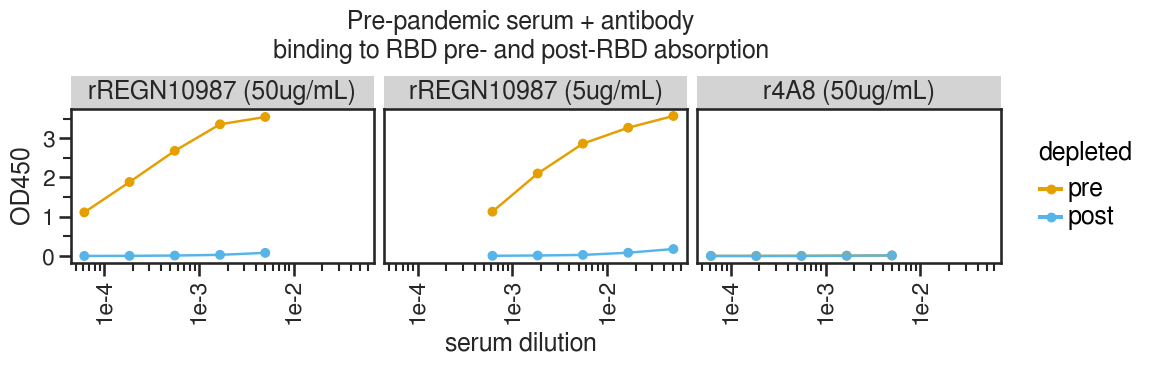

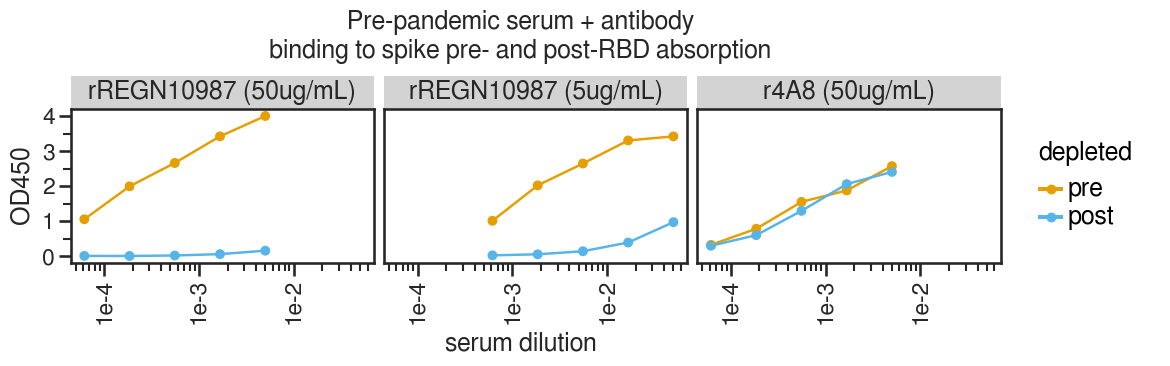

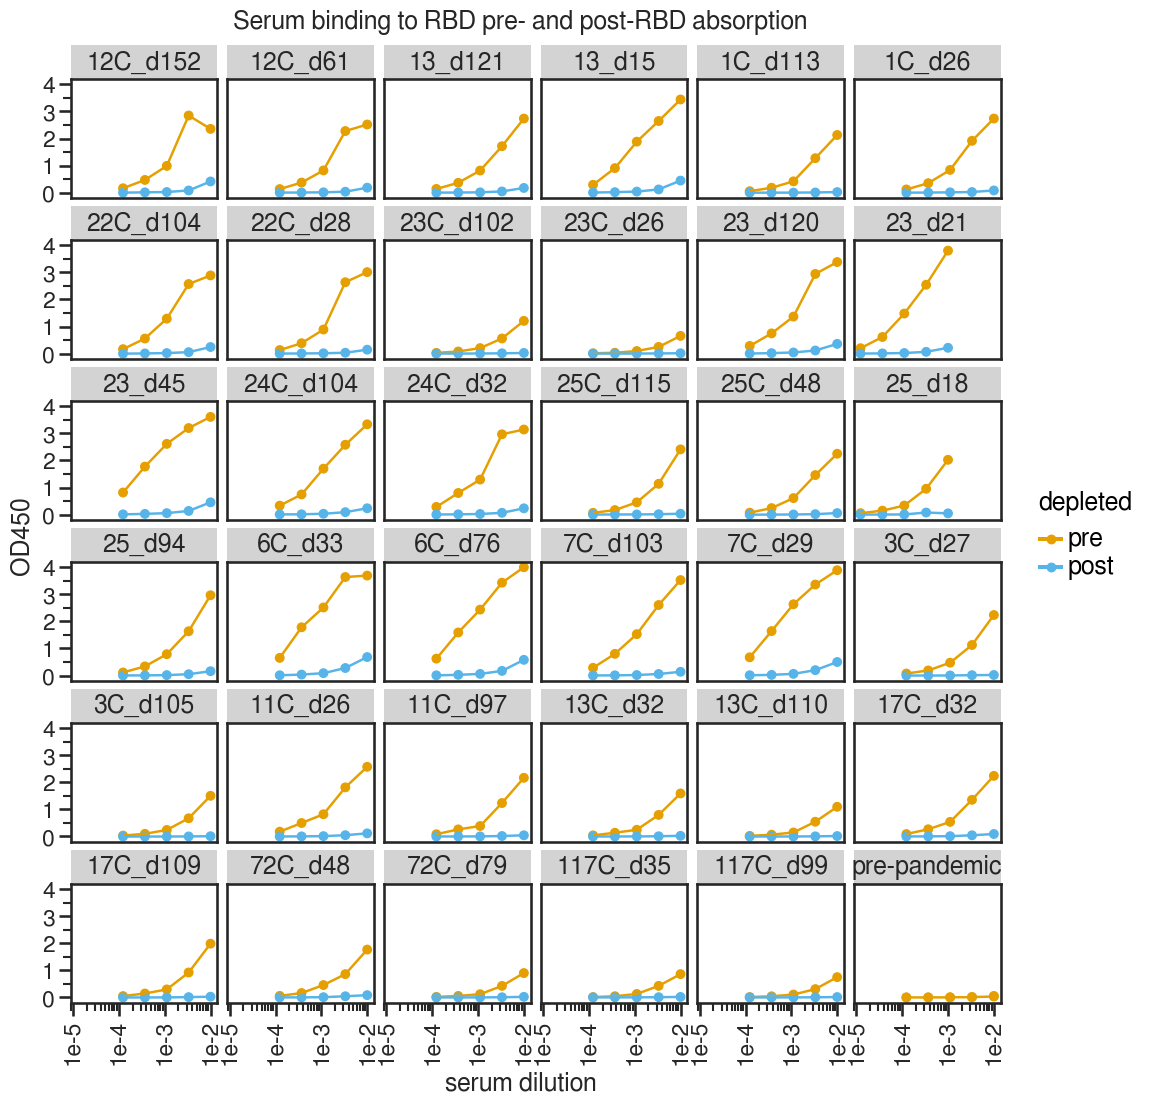

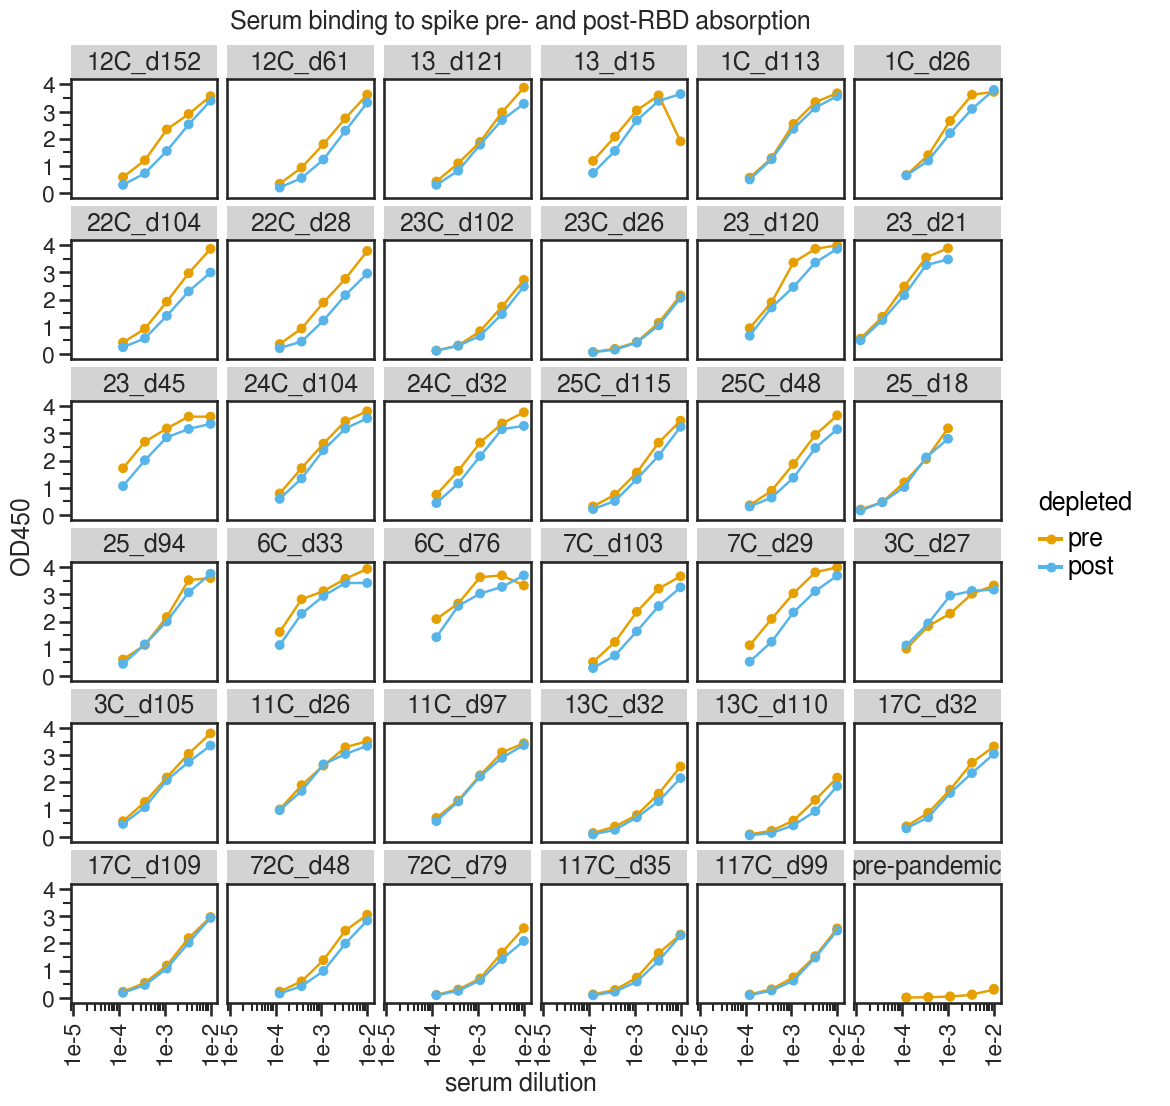

In [9]:
for group in config['depletion_groups']:
    antibody_order = list(group.values())[0]
    for lig in ['RBD', 'spike']:
        df = titration_df.query('ligand==@lig & serum in @antibody_order')
        df['serum'] = pd.Categorical(df['serum'], categories=antibody_order, ordered=True)
        
        nconditions = df['serum'].nunique()
        ncol = 6
        nrow = math.ceil(nconditions / ncol)
        
        if list(group.keys())[0] == 'antibody_controls':
            title = "Pre-pandemic serum + antibody"\
                    f"\nbinding to {lig} pre- and post-RBD absorption"
            
        else:
            title = f"Serum binding to {lig} pre- and post-RBD absorption"
        
        p = (
            ggplot(df,
                   aes('dilution', 
                       'OD450', 
                       group='depleted', 
                       color='depleted')) +
            geom_point(size=3) +
            geom_line(aes(group='depleted'), size=1) +
            scale_x_log10(name='serum dilution') +
            facet_wrap('~ serum', ncol=ncol) +
            ggtitle(title) +
            theme(figure_size=(2 * ncol, 2 * nrow),
                  axis_text_x=element_text(angle=90),
                  subplots_adjust={'hspace':0.35}) +
            scale_color_manual(values=CBPALETTE[1:]) 
            )

        _ = p.draw()
        p.save(f'./{resultsdir}/{list(group.keys())[0]}_{lig}_depletion.png')

### Plot spike and RBD ELISA curves on the same graph 

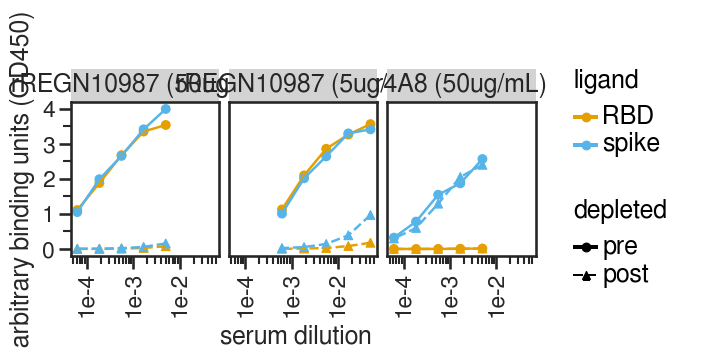

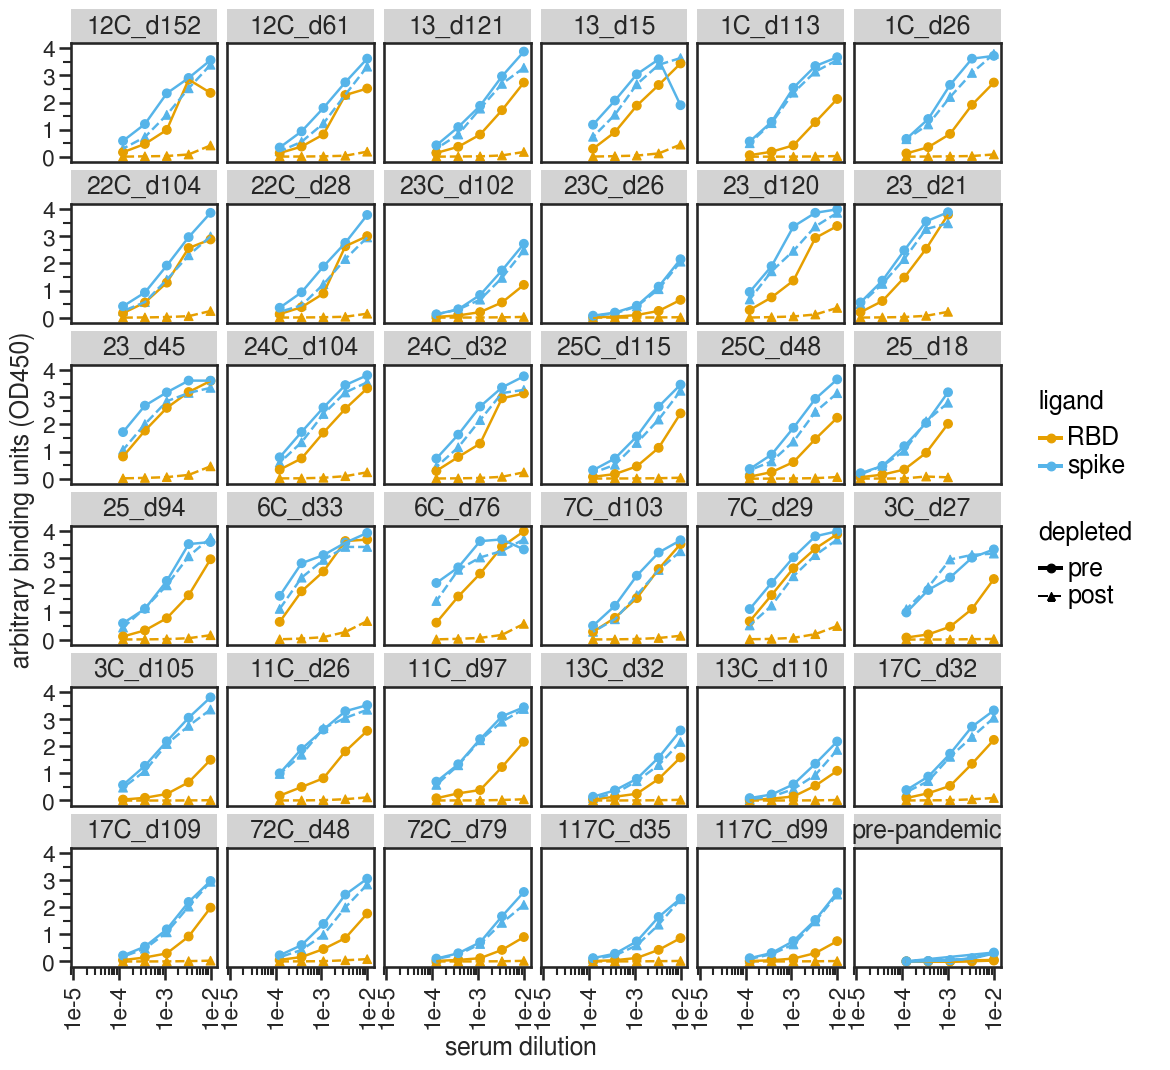

In [10]:
for group in config['depletion_groups']:
    antibody_order = list(group.values())[0]
    #for lig in ['RBD', 'spike']:
    df = titration_df.query('serum in @antibody_order')
    df['serum'] = pd.Categorical(df['serum'], categories=antibody_order, ordered=True)

    nconditions = df['serum'].nunique()
    ncol = np.minimum(6, nconditions)
    nrow = math.ceil(nconditions / ncol)

    p = (
        ggplot(df,
               aes('dilution', 
                   'OD450', 
                   color='ligand',
                   shape='depleted')) +
        geom_point(size=3) +
        geom_path(aes(color='ligand', linetype='depleted'), size=1) +
        scale_x_log10(name='serum dilution') +
        facet_wrap('~ serum', ncol=ncol) +
        theme(figure_size=(2 * ncol, 2 * nrow),
              axis_text_x=element_text(angle=90),
              subplots_adjust={'hspace':0.35}) +
        scale_color_manual(values=CBPALETTE[1:]) +
        ylab('arbitrary binding units (OD450)')
        )

    _ = p.draw()
    p.save(f'./{resultsdir}/{list(group.keys())[0]}_depletion.png')

### Calculate area under curves (AUCs)

Calculate area under curve (AUC) for each ELISA. Note that these are areas calculated using a trapezoidal rule between the min and max dilutions with the x-axis being the natural log dilution factor.

The utility of these calculations pre-supposes that each sample has the same dilutions. 

**THIS IS NOT THE CASE FOR OUR DATA**

However, this is the case for the pre- and post-depletion samples for each seurm, which is what really matters. 

In [11]:
auc_df = (
    titration_df
    .query('ab_serum=="serum"')
    .groupby(['serum',
             'depleted',
             'ligand',
             'dilution_or_ugpermL',
             'ab_serum',
             'date',
             'replicate',
             ])
    .apply(lambda g: sklearn.metrics.auc(g['log_dilution'], g['OD450']))
    .rename('AUC')
    .reset_index()
    )

auc_df.head().round(3)

,serum,depleted,ligand,dilution_or_ugpermL,ab_serum,date,replicate,AUC
0,117C_d35,pre,RBD,dilution,serum,201029,1,1.141
1,117C_d35,pre,spike,dilution,serum,201029,1,4.277
2,117C_d35,post,RBD,dilution,serum,201029,1,0.025
3,117C_d35,post,spike,dilution,serum,201029,1,3.696
4,117C_d99,pre,RBD,dilution,serum,201108,1,0.921


### Get mean AUC for "background sample": the pre-pandemic 2017-2018 serum pool

In [12]:
elisa_background_sample = config['elisa_background_sample']
background = (auc_df
              .query('serum==@elisa_background_sample')
              .groupby(['ligand'])
              .aggregate({'AUC' : 'mean'})
              .reset_index()
             )

background

,ligand,AUC
0,RBD,0.041994
1,spike,0.364025


### Look at AUC pre- vs. post-depletion for each individual (same data as above, but with connecting lines)

The orange dashed line indicates the AUC of the pre-pandemic serum (2017-2018 pooled serum), which was not RBD depleted. 

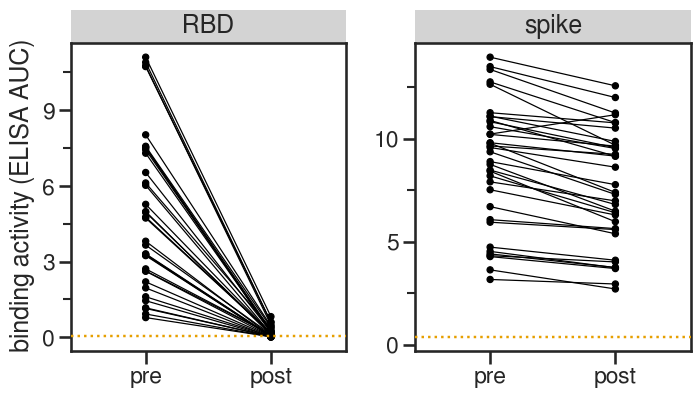

In [13]:
AUC_lines = (ggplot(auc_df
                    .query('serum!=@elisa_background_sample'), 
                    aes(x='depleted', y='AUC', group='serum')) +
                  geom_point(size=2) +
                  geom_line() +
                  facet_wrap('~ ligand', scales='free_y') +
                  theme(axis_text_x=element_text(angle=0, vjust=1, hjust=0.5),
                        figure_size=(8, 4), subplots_adjust={'wspace':0.25},
                        legend_entry_spacing=14) +
                  ylab('binding activity (ELISA AUC)') +
                  xlab('') +
                  # ggtitle('Change in AUC pre- vs. post-RBD absorption') +
             
             # add line for background defined by 2017-2018 serum pool
                  geom_hline(data=background,
                             mapping=aes(yintercept='AUC'),
                             color=CBPALETTE[1],
                             alpha=1,
                             size=1,
                             linetype='dotted',
                            ) 
                 )

_ = AUC_lines.draw()
AUC_lines.save(f'./{resultsdir}/AUC_lines.png')

### Calculate fold-change AUC pre- vs. post-depletion.

We can also sort these values based on fold-change of spike AUC, as we probably expect the most RBD-targeting samples to have the greatest reduction in spike ELISA signal. 

In [14]:
foldchange_auc = (
    auc_df
    .assign(depleted=lambda x: x.depleted.astype(str)) #.columns = df1.columns.astype(list)
    .pivot_table(values='AUC', index=['serum', 'ligand'], columns=['depleted'])
    .reset_index()
    .rename(columns={'post': 'post-depletion_auc', 'pre': 'pre-depletion_auc'})
    .assign(fold_change=lambda x: x['post-depletion_auc'] / x['pre-depletion_auc'],
            reciprocal_fold_change=lambda x: 1/x['fold_change']
           )
    )

foldchange_auc.to_csv(f'{resultsdir}/rbd_depletion_foldchange_auc.csv', index=False)
foldchange_auc.head()

depleted,serum,ligand,post-depletion_auc,pre-depletion_auc,fold_change,reciprocal_fold_change
0,117C_d35,RBD,0.025103,1.140799,0.022005,45.444206
1,117C_d35,spike,3.695842,4.277117,0.864096,1.157278
2,117C_d99,RBD,0.015216,0.921406,0.016514,60.555965
3,117C_d99,spike,4.016801,4.319359,0.929953,1.075323
4,11C_d26,RBD,0.132657,4.953588,0.026780,37.341201


In [15]:
foldchange_wider = (
    foldchange_auc
    .pivot_table(values='reciprocal_fold_change', index=['serum'], columns=['ligand'])
    .reset_index()
    )

foldchange_wider.sort_values(by=['spike'], ascending=False)

ligand,serum,RBD,spike
15,22C_d28,44.410284,1.410935
14,22C_d104,29.454298,1.350778
6,13C_d110,118.197275,1.342885
33,7C_d103,45.257691,1.323709
34,7C_d29,18.413495,1.305718
4,12C_d152,17.168851,1.283885
5,12C_d61,32.985213,1.279916
24,25C_d48,82.590000,1.245489
31,72C_d48,24.394495,1.244637
7,13C_d32,88.240640,1.211984


From a quick by-eye comparison between this sorted list (by fold-change spike AUC) and the fold-change IC50 in neutralizzation assays, there is little relationship between these two. 
So I am not going to worry about this anymore. 
For reference, the samples that had the greatest reduction in NT50 (or increase in IC50) following depletion were:
1. 24C_d104
2. 25_d18
3. 22C_d104
4. 1C_d26
5. 24C_d32
6. 25_d94
7. 1C_d113

For ELISAs, we see a very small decrease in spike AUC following depletion for 24C and 25 samples in particular.
So, I am not going to worry about the ELISA signal anymore and just take the ELISAs as a test of whether the depletion worked or not. 

## Neutralization Assays

### Read in data
* Concatenate the `frac_infectivity` files.
* Remove samples specified in config file. 
* Also remove specified sample / dilution combinations where something has clearly gone wrong experimentally (like forgetting to add virus or cells). 
* Replace `serum` with `display_name`

In [16]:
frac_infect = pd.DataFrame() # create empty data frame
neut_samples_ignore = config['neut_samples_ignore']

for f in config['neut_input_files'].keys():
    df = (pd.read_csv(f, index_col=0).assign(date=config['neut_input_files'][f]))
    frac_infect = frac_infect.append(df).reset_index(drop=True)

print(f"Length before dropping anything = {len(frac_infect.index)}")
    
frac_infect = (frac_infect
        .query('serum not in @neut_samples_ignore')
        .replace({'serum' : config['display_names']})
        .reset_index(drop=True)
       )

print(f"Length after dropping neut_samples_ignore = {len(frac_infect.index)}")

for s in config['neut_ignore_dilutions']:
    dil = config['neut_ignore_dilutions'][s]
    l = len((frac_infect[(frac_infect['serum'] == s) & (frac_infect['concentration'] == dil)]))
    print(f"Dropping {l} rows")
    frac_infect = frac_infect.drop(frac_infect[((frac_infect['serum'] == s) & (frac_infect['concentration'] == dil))].index)
    print(f"Length after dropping {s}: {dil} = {len(frac_infect.index)}")

for s in config['neut_ignore_dates']:
    dat = config['neut_ignore_dates'][s]
    l = len((frac_infect[(frac_infect['serum'] == s) & (frac_infect['date'] == dat)]))
    print(f"Dropping {l} rows")
    frac_infect = frac_infect.drop(frac_infect[((frac_infect['serum'] == s) & (frac_infect['date'] == dat))].index)
    print(f"Length after dropping {s}: {dil} = {len(frac_infect.index)}")

frac_infect.head(2)

Length before dropping anything = 1288
Length after dropping neut_samples_ignore = 1204
Dropping 4 rows
Length after dropping 23C_d26: 0.000205761 = 1200
Dropping 4 rows
Length after dropping 23C_d102: 0.000205761 = 1196
Dropping 28 rows
Length after dropping 24C_d32: 0.000205761 = 1168
Dropping 28 rows
Length after dropping 24C_d104: 0.000205761 = 1140
Dropping 28 rows
Length after dropping 1C_d26: 0.000205761 = 1112


,serum,virus,replicate,concentration,fraction infectivity,date,Unnamed: 6
0,13_d15,pre-depletion,1,0.016667,0.096030,201012,NaN
1,13_d15,pre-depletion,1,0.005556,0.201285,201012,NaN


### Fit Hill curve to data using [`neutcurve`](https://jbloomlab.github.io/neutcurve/)
* Then pivot table, grouping by `serum` and keeping the `serum` and `ic50` columns
* Calculate fold-change ic50 post-depletion vs. pre-depletion
* Take fits.fitParams and drop all the pre-depletion samples 
* Keep `ic50_bound` and merge with fold_change

In [17]:
fits = neutcurve.CurveFits(frac_infect)

fitparams = (
    fits.fitParams()
    .rename(columns={'virus': 'depletion'})
    .assign(NT50=lambda x: 1/x['ic50'])
    # get columns of interest
    [['serum', 'depletion', 'ic50', 'NT50', 'ic50_bound']] 
    )

# couldn't get lambda / conditional statement to work with assign, so try it here:
fitparams['ic50_is_bound'] = fitparams['ic50_bound'].apply(lambda x: True if x!='interpolated' else False)

fitparams.head(2)

,serum,depletion,ic50,NT50,ic50_bound,ic50_is_bound
0,13_d15,pre-depletion,0.001638,610.352369,interpolated,False
1,13_d15,post-depletion,0.006011,166.360761,interpolated,False


### Make horizontal line plot connecting pre- and post-IC50
* Order with greatest fold-change at the top
* Put labels on far right with the % of neutralizing activity targeting the RBD (percent_RBD = 1-(1/foldchange))
* color by pre vs post
* shape is censored
* vertical line for limit of detection

In [18]:
foldchange = (
    fitparams
    .pivot_table(values='ic50', index=['serum'], columns=['depletion'])
    .reset_index()
    .rename(columns={'post-depletion': 'post-depletion_ic50', 'pre-depletion': 'pre-depletion_ic50'})
    .assign(fold_change=lambda x: x['post-depletion_ic50'] / x['pre-depletion_ic50'],
            percent_RBD= lambda x: ((1-1/x['fold_change'])*100).astype(int)
           )
    .merge(fitparams.query('depletion=="post-depletion"')[['serum', 'ic50_is_bound']], on='serum')
    .assign(perc_RBD_str = lambda x: x['percent_RBD'].astype(str)
           )
    .rename(columns={'ic50_is_bound': 'post_ic50_bound'})
    .merge(fitparams)
    )

foldchange['perc_RBD_str'] = np.where(foldchange['post_ic50_bound'], '>'+foldchange['perc_RBD_str']+'%', foldchange['perc_RBD_str']+'%')
foldchange['mapped'] = foldchange['serum'].apply(lambda x: True if x in config['mapped_samples'] else False)

foldchange.head(2)

,serum,post-depletion_ic50,pre-depletion_ic50,fold_change,percent_RBD,post_ic50_bound,perc_RBD_str,depletion,ic50,NT50,ic50_bound,ic50_is_bound,mapped
0,117C_d35,0.020007,0.001628,12.289137,91,False,91%,pre-depletion,0.001628,614.245829,interpolated,False,False
1,117C_d35,0.020007,0.001628,12.289137,91,False,91%,post-depletion,0.020007,49.982830,interpolated,False,False


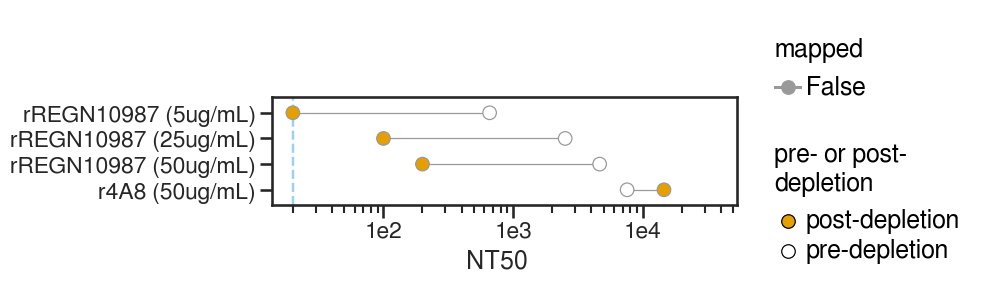

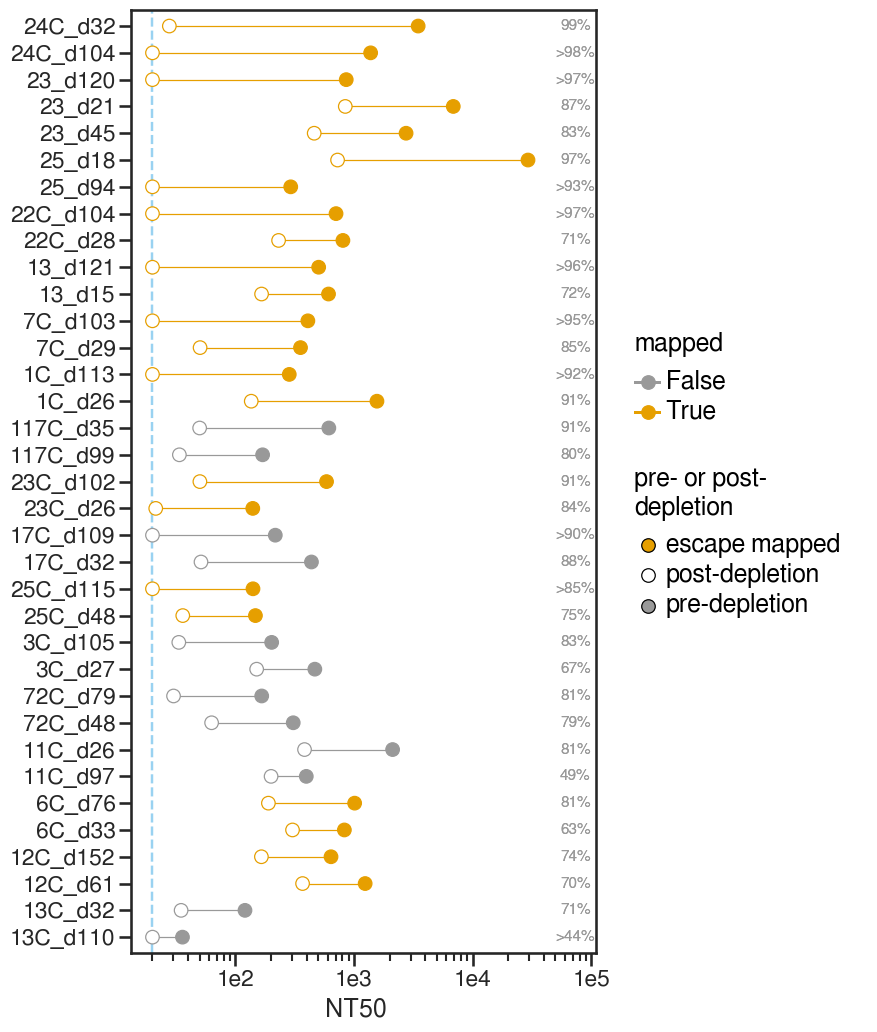

In [19]:
for group in config['depletion_groups']:
    
    sera = list(group.values())[0]
    df = foldchange.query('serum in @sera')
    
    if group == config['depletion_groups'][0]:
        # order sera by fold_change in ascending order 
        serum_order = df.sort_values('fold_change', ascending=True)['serum'].unique()
    else: # split PID_dPSO into 2 columns
        df=(df.assign(PID=lambda x: x['serum'].str.split('_d').str[0],
                            dPSO=lambda x: x['serum'].str.split('_d').str[1].astype(int),
                           )
           )
        
        df=(df.merge((df
                      [['PID', 'serum', 'fold_change']]
                      .groupby('PID')
                      .aggregate({'fold_change' : 'max'})
                      .reset_index()
                      .drop_duplicates()
                      .rename(columns={'fold_change':'max_fc'})
                     ), 
                    how='left', 
                    on='PID'
                   ))
        
        serum_order = df.sort_values(['max_fc', 'fold_change'], ascending=True)['serum'].unique()
    
    
    df = (df
          .assign(serum= pd.Categorical(df['serum'], categories=serum_order, ordered=True) )
          .replace({'pre-depletion': 'pre', 'post-depletion': 'post'})
         )
    df['fill_color'] = 'pre-depletion'
    df.loc[df.mapped == True, 'fill_color'] = 'escape mapped'
    df['fill_color'] = np.where(df['depletion'] == 'post', 'post-depletion', df['fill_color'])
    
    df['depletion']=pd.Categorical(df['depletion'], categories=['pre', 'post'], ordered=True)
    
    nconditions = df['serum'].nunique()
    
    p = (ggplot(df, aes(x='NT50',
                        y='serum',
                        color='mapped',
                        fill='fill_color', 
                        group='serum')) +
         scale_x_log10(name='NT50') +
         geom_vline(xintercept=config['NT50_LOD'], 
                    linetype='dashed', 
                    size=1, 
                    alpha=0.6, 
                    color=CBPALETTE[2]) +
         geom_line(alpha=1) +
         geom_point(size=5) +
         geom_text(aes(x=df['NT50'].max()*2.5, y='serum'), 
                   label=df['perc_RBD_str'],
                   color=CBPALETTE[0]
                  ) +
         ylab('') +
         theme(figure_size=(6, 0.35*nconditions)) +
         scale_color_manual(values=CBPALETTE) +
         scale_fill_manual(values=['#E69F00', '#FFFFFF', '#999999'], name='pre- or post-\ndepletion')
                    )

    _ = p.draw()
    p.save(f'./{resultsdir}/{list(group.keys())[0]}_IC50_lineplot.png')

### Look at fold-change NT50 at the early and late timepoints to see how RBD targeting changes over time.

Saving to ./results/depletion_overtime_facet.pdf


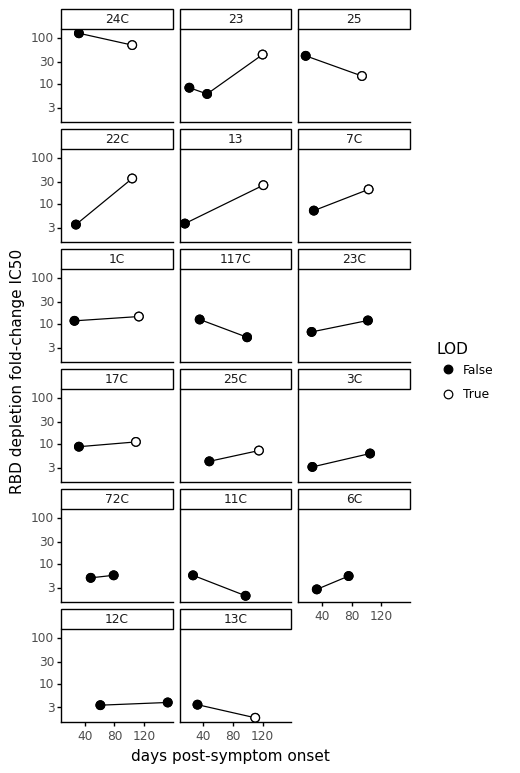

In [20]:
sera = list(config['depletion_groups'][1].values())[0] # these are the sera
    
serum_foldchange = (foldchange
                    .query('serum in @sera')
                    .assign(PID=lambda x: x['serum'].str.split('_d').str[0],
                            dPSO=lambda x: x['serum'].str.split('_d').str[1].astype(int),
                           )
                   )
serum_foldchange['dPSO_group'] = (serum_foldchange['dPSO']
                                  .apply(lambda x: 'early' if x<=45 else 'late')
                                 )

# This would manually define serum plotting order according to config file
# sera_PID = [x.split('_d')[0] for x in sera]
# PID_order = list(dict.fromkeys(sera_PID))

# Instead, define serum plotting order according to max_fc for one PID
PID_order = serum_foldchange.sort_values('fold_change', ascending=False)['PID'].unique()
serum_foldchange['PID'] = pd.Categorical(serum_foldchange['PID'], categories=PID_order, ordered=True)

nconditions = serum_foldchange['serum'].nunique()
ncol = 3 if nconditions >= 3 else nconditions
nrow = math.ceil(nconditions / ncol)

p = (ggplot(serum_foldchange
           ) +
     aes('dPSO', 'fold_change', group='PID', fill='ic50_is_bound') +
     geom_line(aes(group='PID'), size=0.5) +
     geom_point(size=3, alpha=1) +
     scale_y_log10() +
     facet_wrap('~ PID', ncol=ncol) +
     theme_classic() +
     theme(
           figure_size=(1.5 * ncol, 0.75 * nrow),
           ) +
     xlab('days post-symptom onset') +
     ylab('RBD depletion fold-change IC50') +
     labs(fill='LOD') +
     scale_fill_manual(values=['black', 'white'])
     )

_ = p.draw()

plotfile = f'./{resultsdir}/depletion_overtime_facet.pdf'
print(f"Saving to {plotfile}")
p.save(plotfile, verbose=False)

This is great! 
We can see that for several samples, the fold-change in IC50 is even greater than was observed for the monoclonal antibody, rREGN10987. 
Our fold-change is limited by two factors:
1. The IC50 of the pre-depletion sample (the more potent the pre-depletion IC50, the greater magnitude of change we are able to detect)
2. The dilutions used on the post-depletion sample, which determine the bounds or upper limit of IC50 that can be calculated.

For a number of samples, our post-depletion IC50 is bound because `neutcurve` is unable to determine an IC50 with the dilutions we used. 
So, do keep this in mind when interpreting the fold-change IC50.
However -- the max fold-change we are able to detect is related to the potency of the pre-depletion serum, and we probably want to be using the *most potent sera* that are *the most RBD-targeting* so I think we can still find these bounded numbers as useful. 

## Plot neut curves for all samples

In [21]:
foldchange = (foldchange
              .assign(NT50_pre = lambda x: 1/x['pre-depletion_ic50'],
                      NT50_post = lambda x: 1/x['post-depletion_ic50'],
                     )
              .drop(columns=['depletion', 'ic50', 'NT50', 'ic50_bound', 'ic50_is_bound'])
              .drop_duplicates()
             )
foldchange.head(2)

,serum,post-depletion_ic50,pre-depletion_ic50,fold_change,percent_RBD,post_ic50_bound,perc_RBD_str,mapped,NT50_pre,NT50_post
0,117C_d35,0.020007,0.001628,12.289137,91,False,91%,False,614.245829,49.98283
2,117C_d99,0.029650,0.005892,5.032618,80,False,80%,False,169.735567,33.72709


['rREGN10987 (50ug/mL)', 'rREGN10987 (25ug/mL)', 'rREGN10987 (5ug/mL)', 'r4A8 (50ug/mL)']
['12C_d152', '12C_d61', '13_d121', '13_d15', '1C_d113', '1C_d26', '22C_d104', '22C_d28', '23C_d102', '23C_d26', '23_d120', '23_d21', '23_d45', '24C_d104', '24C_d32', '24C_d32r', '25C_d115', '25C_d48', '25_d18', '25_d94', '6C_d33', '6C_d76', '7C_d103', '7C_d29', '3C_d27', '3C_d105', '11C_d26', '11C_d97', '13C_d32', '13C_d110', '17C_d32', '17C_d109', '72C_d48', '72C_d79', '117C_d35', '117C_d99', 'pre-pandemic']


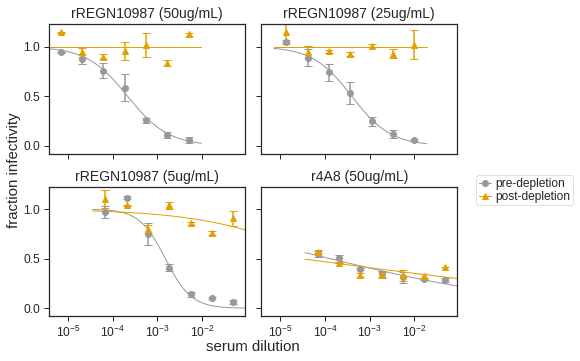

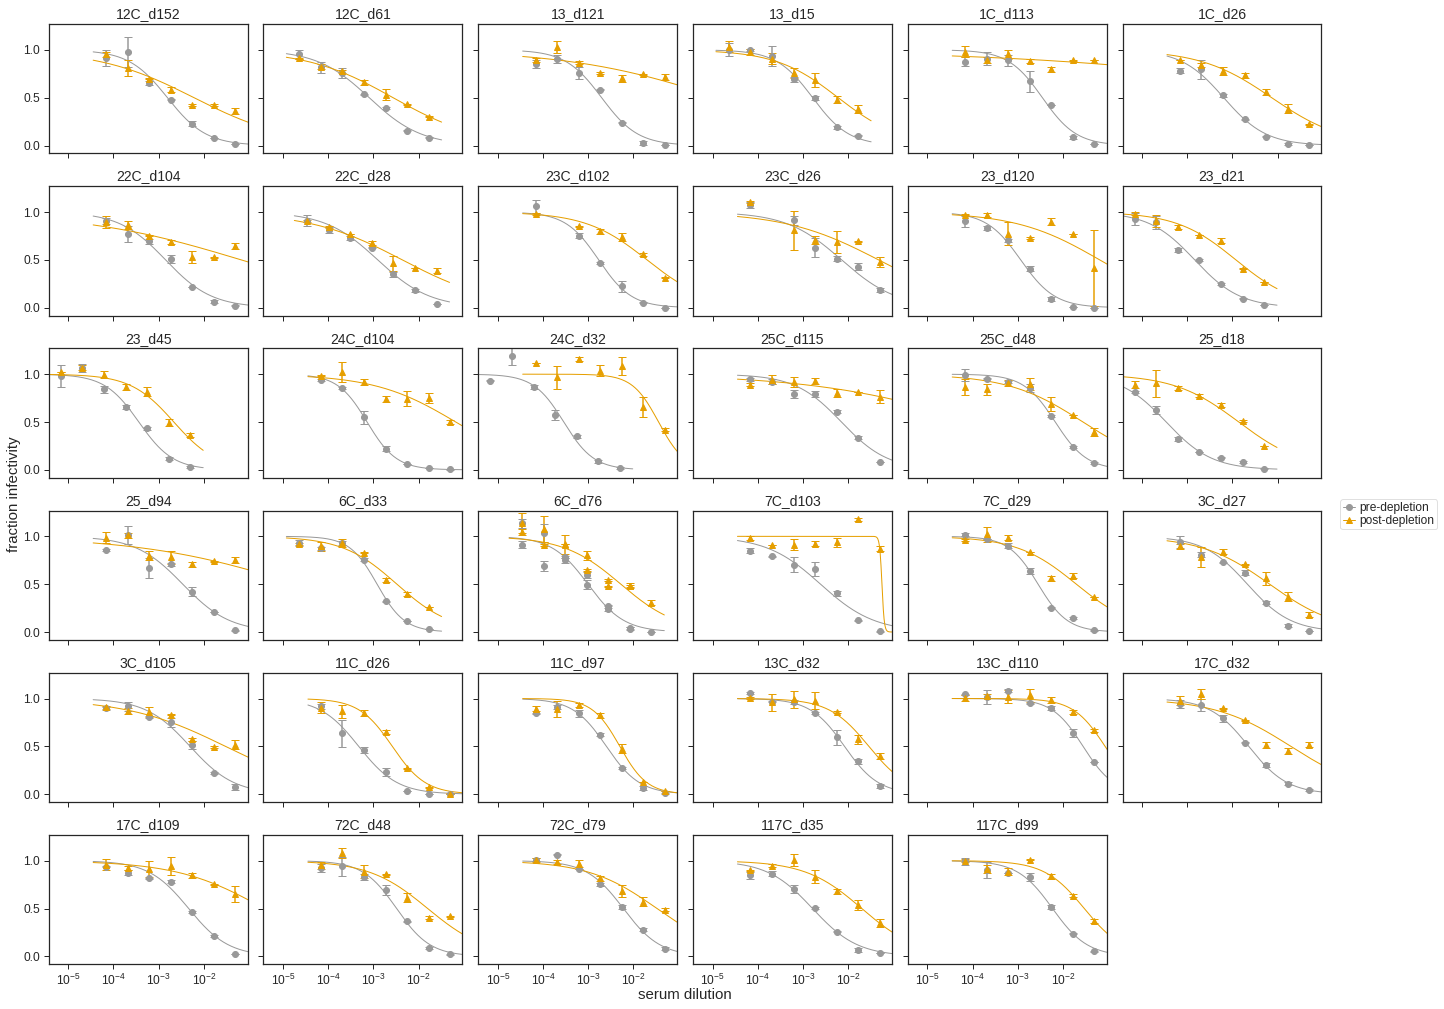

In [22]:
for group in config['depletion_groups']:
    antibody_order = list(group.values())[0]
    print(antibody_order)
    plot_df = (foldchange
               .query('serum in @antibody_order')
              )
    plot_df['serum'] = pd.Categorical(plot_df['serum'], categories=antibody_order, ordered=True)
    
    fig, axes = fits.plotSera(sera=[i for i in antibody_order if i in plot_df['serum'].tolist()],
                              xlabel='serum dilution',
                              ncol=math.ceil(np.minimum(len([i for i in antibody_order if i in plot_df['serum'].tolist()])/2, 6))
                             )

    # save plot files
    plotfile = PdfPages(f'{resultsdir}/{list(group.keys())[0]}_frac_infectivity.pdf')
    plotfile.savefig(bbox_inches='tight', transparent=True)
    plotfile.close()

### Compare pre-depletion IC50s to [Kate's published data](https://academic.oup.com/jid/advance-article/doi/10.1093/infdis/jiaa618/5916372)

First read in [Supplementary File 2](https://oup.silverchair-cdn.com/oup/backfile/Content_public/Journal/jid/PAP/10.1093_infdis_jiaa618/1/jiaa618_suppl_supplementary_files_2.xlsx?Expires=1607057702&Signature=y8OMaiRqv333yv75g3X1SlHt9p-c98RXQvIm-q8ZmNaDlTHIIVlhoD8L1NXt8mWwDvEfFioxsoVpArW60VQ4mjPV-Qmu7O5N9-eKnnFeBincOg1fKxBBkzAe1TeT2NtqnAXFTEcZD30~Kt4UwViVxZUH8SMn4NuStwRREfG6C23TWTDTMLr9tlISxVZW65Cz0vK0hbhLv~3mC8IXes6mUh6VrHVDdSTmUBk0SN4Dhv6gLcMEmltdVHRgBFuuLFTq-VPRm7z43XV1FYiorDDrS6nmqihYtSQNV6sdbA2obqKDHt3xEcOK-ln~vtLcT0-FQ94p-1lFkf4h8-ebGrzLQw__&Key-Pair-Id=APKAIE5G5CRDK6RD3PGA). 
Then merge with our new data. 
Plot Kate's vs. Andrea's IC50s (Andrea's are done with D614G, but Kate's were done with D614).

In [23]:
# Read in Kate's data, merge with `foldchange`
published_data = (pd.read_csv(config['published_metadata'], 
                              dtype={'Days Post-Symptom Onset': int}, 
                              index_col=0)
                  .assign(PID_date = lambda x: x['Participant ID'] + '_d' + x['Days Post-Symptom Onset'].astype(str))
                  .rename(columns={"IC50": "IC50_D614", "NT50": "NT50_D614"})
                 )

foldchange = (pd.merge(foldchange,
                     published_data,
                     how='inner',
                     left_on='serum',
                     right_on='PID_date')
           .assign(logNT50_D614 = lambda x: np.log(x.NT50_D614),
                   logNT50_G614 = lambda x: np.log(x.NT50_pre)
                  )
          )

corr, _ = scipy.stats.pearsonr(foldchange['logNT50_D614'], foldchange['logNT50_G614'])
print(f'Pearsons correlation: {corr}'.format())
foldchange.head(2)

Pearsons correlation: 0.8755792729320929


,serum,post-depletion_ic50,pre-depletion_ic50,fold_change,percent_RBD,post_ic50_bound,perc_RBD_str,mapped,NT50_pre,NT50_post,...,Days Post-Symptom Onset,IC50_D614,NT50_D614,RBD IgA,RBD IgG,RBD IgM,Spike IgG,PID_date,logNT50_D614,logNT50_G614
0,117C_d35,0.020007,0.001628,12.289137,91,False,91%,False,614.245829,49.98283,...,35,0.003957,252.696982,2.476546,5.111019,0.757818,10.060048,117C_d35,5.532191,6.420395
1,117C_d99,0.029650,0.005892,5.032618,80,False,80%,False,169.735567,33.72709,...,99,0.008373,119.434981,1.750474,4.282665,0.481807,9.145068,117C_d99,4.782772,5.134242


Saving to ./results/Crawford_Loes_NT50.pdf


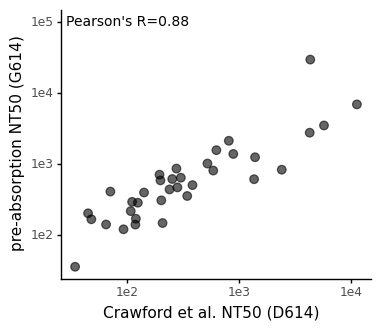

In [24]:
p = (ggplot(foldchange) +
     aes('NT50_D614', 'NT50_pre') +
     geom_point(size=3, alpha=0.6) +
     scale_x_log10() +
     scale_y_log10() +
     theme_classic() +
     theme(figure_size=(4, 3.5),
           ) +
     xlab('Crawford et al. NT50 (D614)') +
     ylab('pre-absorption NT50 (G614)') +
     annotate("text", 
              label = "Pearson's R={:.2f}".format(corr), 
              x = 100, 
              y = 100000, 
              size = 10,
              
             )
     )

_ = p.draw()

plotfile = f'./{resultsdir}/Crawford_Loes_NT50.pdf'
print(f"Saving to {plotfile}")
p.save(plotfile, verbose=False)

Save `foldchange` file

In [25]:
foldchange.to_csv(f'{resultsdir}/rbd_depletion_foldchange.csv', index=False)

In [26]:
# !jupyter nbconvert rbd_depletions.ipynb --to html